2022.12.30  
MovieLens dataset に寄せるため，出力するファイル名を変更する

2022.12.22  
二部グラフを前提とした "texts - hashtags" の構造を作る

In [60]:
import csv
import re
import glob

# ばかでかい CSV を扱うための指定
csv.field_size_limit(1000000000)

'''
投稿テキストからハッシュタグを抽出
(例)
投稿テキスト1 : ○○○ #A #B
投稿テキスト2 : ○○○ #B
投稿テキスト3 : ○○○ #B #C #D
→ 返し値 : [[#A, #B], [#B], [#B, #C, #D]]
'''
def extract_text_hashtags(filename, removed_tags=[]): 
    ret = list()
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            # エラーハンドリング （何故，len(row) < 5 が起きるか，分からないが・・・
            if len(row) < 5:
                continue
                
            original_text = row[4]

            # ハッシュタグをリストとして取り出す
            # (参考) https://python-man.club/python_twitter_hashtags/
            # hash_list = re.findall(r"#\S*", original_text)
            # (参考) https://teratail.com/questions/299251
            hash_list = re.findall(r"#[^#\s]*", original_text)

            # removed_tags に含まれるタグをテキストから除く
            for tag in hash_list:
                if tag in removed_tags:
                    original_text = original_text.replace(tag, "")

            # removed_tags に含まれるタグをテキストから除く
            '''
            for rt in removed_tags:
                original_text = original_text.replace(rt, "")
            '''
                
            # 改めて，ハッシュタグをリストとして取り出す
            # (参考) https://python-man.club/python_twitter_hashtags/
            # hash_list = re.findall(r"#\S*", original_text)
            # (参考) https://teratail.com/questions/299251
            hash_list = re.findall(r"#[^#\s]*", original_text)
 
            # removed_tags に含まれるタグを有するツイートを除去する
            '''
            inter = set(hash_list).intersection(set(removed_tags))
            if len(inter) > 0:
                continue
            '''
                        
            if len(hash_list) > 0:
                ########hashtag_list.append(hash_list)
                
                # ハッシュタグより前部分を取り出す・・・(メモ)タグが１個，かつ末尾に存在するのが前提のコード
                '''
                idx = original_text.index(hash_list[0])
                text = original_text[:idx].rstrip() #(' ')
                '''
                
                # ハッシュタグを取り除いたテキストを取り出す
                text = original_text
                for tag in hash_list:
                    text = text.replace(tag, "")
                '''
                if len(text) == 0:
                    continue
                '''

                ret.append({"text":text, "hashtag":hash_list, "original_text":original_text})
    return ret

In [61]:
# 東京オリンピック期間の日付(7/23-8/8)からパスを生成
from datetime import date, timedelta

def make_olympic_dates():
    parent_path = "/home/muto/Dropbox/ExpSSE3/Tweets/"
    filenames = list()
    d = date(2021, 7, 24)
    # while d <= date(2021, 8, 8):
    while d <= date(2021, 7, 26):
        s_date = d.strftime("%Y%m%d")
        print(s_date)
        filenames.append(parent_path + s_date + "_olympic.txt")
        d += timedelta(days=1)
        
    return filenames


In [62]:
# 分析対象とするデータセット
# filename = "/home/muto/Dropbox/ExpSSE3/Tweets_2022/corona/20220628_corona.txt"
# path = "/home/muto/Dropbox/ExpSSE3/Tweets_2022/corona/2022062?_corona.txt"
# filenames = glob.glob(path)

filenames = make_olympic_dates()

20210724
20210725
20210726


## TODO: 全てのタグの出現回数を数えて，その回数が 10回未満のタグを取り除く
具体的にはremoved_tags に加える

In [63]:
'''
出現頻度の低いタグを抽出
'''
hashtag_stock = [] # 頻出するハッシュタグを調べるため，一旦，ストックする

# 各投稿からハッシュタグのリストを抽出
result = []
for filename in filenames:
    results = extract_text_hashtags(filename)
    # print(ret)

    for result in results:
        for tag in result['hashtag']:
            # (参考) 頻出するハッシュタグを調べるため，一旦，ストックする
            hashtag_stock.append(tag)
            
# hashtag_stock の中身を調べる
import collections
count = collections.Counter(hashtag_stock)
count.most_common() # 出現回数が多い方から出力

values, counts = zip(*count.most_common())

import pandas as pd
df = pd.DataFrame({"tag":list(values), "count":list(counts)})

# 出現回数が10未満のタグを取り出す
new_df = df.copy()
# new_df = new_df[df['count'] < 10]
new_df = new_df[df['count'] < 100]
low_freq_tags = new_df['tag'].values
low_freq_tags

array(['#スポーツ', '#njpw', '#柔道男子60キロ級', ..., '#wasimo', '#わしも',
       '#ＮＨＫに国会中継を求めます'], dtype=object)

In [64]:
text_ids = [] # for DataFrame
texts = [] # for DataFrame
original_texts = [] # for DataFrame

hashtag_ids = []
hashtags = []

text2tag_text_ids = []
text2tag_tag_ids = []

text_id = 0 # ゼロ・オリジンでなく，1 オリジンとする
hashtag_id = 0 # ゼロ・オリジンでなく，1 オリジンとする

hashtag_stock = [] # 頻出するハッシュタグを調べるため，一旦，ストックする

# 除去するタグ（出現回数が多すぎるため）
removed_tags = ['#オリンピック', '#Tokyo2020','#東京2020',
                '#開会式','#東京オリンピック', '#Olympics', '#tokyo2020',
                '#東京五輪', '#TokyoOlympics', '#TOKYO2020', '#OpeningCeremony',
                '#五輪', '#東京オリンピック開会式', '#東京オリンピック2020',
                '#東京2020オリンピック', '#TokyoOlympics2021',
                '#NHK', '#OlympicGames','#NHK2020', '#nhk', "#デイリーハイライト"]
'''
removed_tags = []
'''

# 明示的に削除するタグ ＆ 出現頻度の低いタグを除く
removed_tags = removed_tags + list(low_freq_tags)

# removed_tags = []

# 各投稿からハッシュタグのリストを抽出
result = []
for filename in filenames:
    results = extract_text_hashtags(filename, removed_tags=removed_tags)
    # print(ret)

    for result in results:
        #print(result['text']) # for DEBUG
        #print(result['hashtag']) # for DEBUG

        text_ids.append(text_id)
        texts.append(result['text'])
        original_texts.append(result['original_text'])

        for tag in result['hashtag']:
            # (参考) 頻出するハッシュタグを調べるため，一旦，ストックする
            hashtag_stock.append(tag)
            
            if tag not in hashtags:
                hashtag_ids.append(hashtag_id)
                hashtags.append(tag)
                
                text2tag_text_ids.append(text_id)
                text2tag_tag_ids.append(hashtag_id)

                hashtag_id += 1
            else:
                text2tag_text_ids.append(text_id)
                
                tmp_hashtag_id = hashtags.index(tag)
                text2tag_tag_ids.append(tmp_hashtag_id)

        text_id += 1
            
import pandas as pd
df_text = pd.DataFrame({'text_id':text_ids, 'text':texts, 'original_text':original_texts})
df_hashtag = pd.DataFrame({'movie_id':hashtag_ids, 'title':hashtags})
# df_text2hashtag = pd.DataFrame({'user_id':text2tag_text_ids, 'movie_id':text2tag_tag_ids})
df_text2hashtag = pd.DataFrame({'user_id':text2tag_text_ids,
                                'movie_id':text2tag_tag_ids})

import pickle
with open('df_text.pkl', 'wb') as f:
    pickle.dump(df_text, f)

with open('movies.pkl', 'wb') as f:
    pickle.dump(df_hashtag, f)

with open('ratings.pkl', 'wb') as f:
    pickle.dump(df_text2hashtag, f)

In [65]:
len(removed_tags)

28257

In [66]:
df_text

,text_id,text,original_text
0,0,あー色々見るのなかなか大変やね 今日見れたやつ 🥇🥈👏 なでしこ だった...,あー色々見るのなかなか大変やね 今日見れたやつ #卓球 #ウエイトリフティング #体操競...
1,1,その③ 開会式のピクトグラム順,その③ #自転車ロード #マウンテンバイク #トライアスロン 開会式のピクトグラム順...
2,2,ペン投げトレンド入りはオリンピック感じますねえ〜👍👍,ペン投げトレンド入りはオリンピック感じますねえ〜👍👍 #SixTONESANN
3,3,競技を終えた五輪選手(特にゴールドメダリスト)にはインタビューや記者会見でテレ朝やT...,#テレビ朝日 #TBS 競技を終えた五輪選手(特にゴールドメダリスト)にはインタビューや...
4,4,多少国民死んでもオリンピックやれば皆夢中になるから問題ないね！じゃないのよ,多少国民死んでもオリンピックやれば皆夢中になるから問題ないね！じゃないのよ #いまからでも...
...,...,...,...
86116,86116,命や感染者数っていうのは「目に見える」し、「数字に表れる」のに対して、「スポーツの熱狂」によ...,命や感染者数っていうのは「目に見える」し、「数字に表れる」のに対して、「スポーツの熱狂」によ...
86117,86117,やっぱり自国開催はいいね。 一部声のでかい少数がいる様だけど それが大多数となったとしても ...,やっぱり自国開催はいいね。 一部声のでかい少数がいる様だけど それが大多数となったとしても ...
86118,86118,やっぱりオリンピック用の設定できてるや。 がこうなったのもこういうことですねwwww,#JPN やっぱりオリンピック用の設定できてるや。 がこうなったのもこういうことですねwwww
86119,86119,ん－ーーーーーーーこれはーーーーーーーハンドじゃーーーーーーーーないかなぁｗ （見逃し視聴...,ん－ーーーーーーーこれはーーーーーーーハンドじゃーーーーーーーーないかなぁｗ （見逃し視聴...


In [59]:
df_hashtag

,movie_id,title
0,0,#卓球
1,1,#ウエイトリフティング
2,2,#体操競技
3,3,#柔道
4,4,#サッカー
...,...,...
212,212,#スケボー女子
213,213,#SZ_夏のハイドレンジア
214,214,#五輪スポンサーの不買運動はじめよう
215,215,#おは戦30726jg


In [110]:
# hashtag_stock の中身を調べる
import collections
count = collections.Counter(hashtag_stock)
count.most_common() # 出現回数が多い方から出力

[('#柔道', 2980),
 ('#自転車ロード', 2591),
 ('#バレーボール', 1035),
 ('#ソフトボール', 954),
 ('#CyclingRoad', 950),
 ('#jspocycle', 849),
 ('#報道特集', 577),
 ('#オリンピック開会式', 544),
 ('#ロードレース', 514),
 ('#五輪やめて命まもれ', 466),
 ('#競泳', 456),
 ('#IOCバッハ会長マイクロビキニ部', 449),
 ('#バドミントン', 427),
 ('#3x3', 403),
 ('#卓球', 366),
 ('#がんばれニッポン', 331),
 ('#東京五輪の中止を求めます', 304),
 ('#孤独のグルメ', 284),
 ('#男子バレー', 283),
 ('#内村航平', 278),
 ('#金メダル', 277),
 ('#高藤直寿', 262),
 ('#村上信五', 258),
 ('#サッカー', 252),
 ('#体操競技', 251),
 ('#Tokyo2021', 248),
 ('#ホッケー', 238),
 ('#龍神NIPPON', 235),
 ('#体操', 229),
 ('#テニス', 226),
 ('#なでしこジャパン', 220),
 ('#ピクトグラム', 216),
 ('#いまからでも五輪中止を', 210),
 ('#渡名喜風南', 193),
 ('#アーチェリー', 189),
 ('#五輪やめて命守れ', 183),
 ('#mitazo', 182),
 ('#でじたる大喜利', 180),
 ('#おは戦30724jd', 177),
 ('#ウェークアップ', 177),
 ('#ハンドボール', 172),
 ('#テコンドー', 171),
 ('#ロードレースjp', 171),
 ('#自転車ロードレース', 166),
 ('#ウエイトリフティング', 162),
 ('#女子サッカー', 154),
 ('#日本', 149),
 ('#レオスの実験室', 149),
 ('#Judo', 143),
 ('#ニュースキャスター', 141),
 ('#男子バレーボール', 140),
 ('#バスケッ

## 以下は中身チェック

In [11]:
df_text

,text_id,text,original_text
0,0,ペン投げトレンド入りはオリンピック感じますねえ〜👍👍,ペン投げトレンド入りはオリンピック感じますねえ〜👍👍 #SixTONESANN
1,1,時差なくオリンピックが観られるのはいいですね！ 寝不足にならないし！,時差なくオリンピックが観られるのはいいですね！ 寝不足にならないし！ #東京2020オリンピック
2,2,多少国民死んでもオリンピックやれば皆夢中になるから問題ないね！じゃないのよ,多少国民死んでもオリンピックやれば皆夢中になるから問題ないね！じゃないのよ #いまからでも...
3,3,凄い❗オリンピック始まったらニュースやらなくなっちゃった。スポーツ見たく無い人が見るものが無...,凄い❗オリンピック始まったらニュースやらなくなっちゃった。スポーツ見たく無い人が見るものが無...
4,4,昨日も今日も…やるはずだったたくさんのイベントが中止になっているはず。悔しくて悲しくてたまら...,昨日も今日も…やるはずだったたくさんのイベントが中止になっているはず。悔しくて悲しくてたまら...
...,...,...,...
7778,7778,開会式のピクトグラムを人間で表現しようなんて私のアイディアがきっかけですよね…？ 間違いなく...,開会式のピクトグラムを人間で表現しようなんて私のアイディアがきっかけですよね…？ 間違いなく...
7779,7779,オリンピック非正規種目の飯テロの時間だ‼️,オリンピック非正規種目の飯テロの時間だ‼️ #孤独のグルメSeason9
7780,7780,東京オリンピックの目玉はなんといっても最高にかわいい,東京オリンピックの目玉はなんといっても最高にかわいい #ミライトワ くんと #ソメイティ ち...
7781,7781,祝え！！！！！！！！ オリンピックとかおれのための誕生会やから。はは。世界から祝われるなんて...,祝え！！！！！！！！ オリンピックとかおれのための誕生会やから。はは。世界から祝われるなんて...


In [20]:
df_hashtag[:200].values

array([[0, '#五輪やめて命守れ'],
       [1, '#Zガンダム'],
       [2, '#乃木坂工事中'],
       [3, '#NHK総合'],
       [4, '#開催してよかったわけねえだろ'],
       [5, '#Olympics'],
       [6, '#村上信五'],
       [7, '#フジテレビ'],
       [8, '#オリンピックキャスター'],
       [9, '#Eテレ'],
       [10, '#tokyo2020'],
       [11, '#クラシック音楽館'],
       [12, '#パリの映像'],
       [13, '#ジョン・ウィリアムズ'],
       [14, '#奄美リゾフェス'],
       [15, '#ミクチャ'],
       [16, '#RT数が審査対象になってます'],
       [17, '#Going'],
       [18, '#亀梨和也'],
       [19, '#オリンピック開催して良かった'],
       [20, '#Tokyo2020'],
       [21, '#Paris2024'],
       [22, '#jspocycle'],
       [23, '#パリ五輪'],
       [24, '#閉会式'],
       [25, '#情熱大陸'],
       [26, '#ギャルと恐竜6巻オレンジ'],
       [27, '#真夏の夜のコンサート'],
       [28, '#東京五輪'],
       [29, '#東京2020'],
       [30, '#フェンシング'],
       [31, '#Fencing'],
       [32, '#東京オリンピック'],
       [33, '#オリンピック'],
       [34, '#五輪'],
       [35, '#橋本大輝'],
       [36, '#体操競技'],
       [37, '#意味不明'],
       [38, '#ほぼ毎日プリンピック'],
       [39, '#MIKIKOチーム版'],
       [40

In [21]:
df_text2hashtag

,user_id,movie_id
0,0,0
1,1,1
2,1,2
3,2,3
4,3,4
...,...,...
734796,335462,2947
734797,335463,50362
734798,335464,6051
734799,335464,19870


In [50]:
# グラフを作る
def func_text(x):
    return 'text_' + str(x)

def func_hashtag(x):
    return 'tag_' + str(x)

# 準備
tmp = df_text2hashtag.copy()
tmp['text'] = tmp['text_id'].apply(func_text)
tmp['hashtag'] = tmp['hashtag_id'].apply(func_hashtag)

# リスト内包表記でいく方が楽！！！！

source = tmp['text'].to_list()
target = tmp['hashtag'].to_list()
import networkx as nx
edges = pd.DataFrame({'source': source,
               'target': target,
               'weight':[1]*len(source)})
G = nx.from_pandas_edgelist(edges, edge_attr=True)

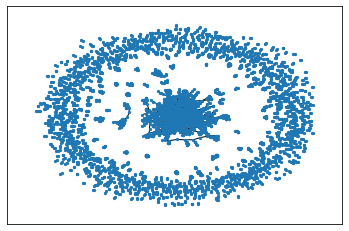

In [51]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos,
                 with_labels=False,
                 node_size=5)